In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import datetime
import os
import pandas as pd
import numpy as np
import pkg_resources
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn import metrics

%matplotlib inline

# autoreload makes it easier to interactively work on code in imported libraries
%load_ext autoreload
%autoreload 2

# Set pandas display options so we can read more of the comment text.
pd.set_option('max_colwidth', 300)

import model_bias_analysis

# Load and pre-process Madlibs data

In [2]:
# Read madlibs dataset, convert Label to Booleans
madlibs_df = pd.read_csv('eval_datasets/bias_madlibs_77k_scored_prod_models.csv')
madlibs_df.loc[madlibs_df.Label == 'BAD', 'Label'] = True
madlibs_df.loc[madlibs_df.Label == 'NOT_BAD', 'Label'] = False
# Needed for AUC metrics to work properly
madlibs_df['Label'] = madlibs_df['Label'].astype(bool)

In [3]:
# Add boolean identity columns, e.g. "hug american" should have True in the "american" column.
madlibs_identity_terms = model_bias_analysis.read_identity_terms('bias_madlibs_data/adjectives_people.txt')
model_bias_analysis.add_subgroup_columns_from_text(madlibs_df, 'Text', madlibs_identity_terms)
madlibs_df.head()

,Label,Template,Text,id,RockV6_2:TOXICITY,Rock:TOXICITY,lesbian,gay,bisexual,transgender,...,older,young,younger,teenage,millenial,middle aged,elderly,blind,deaf,paralyzed
0,True,verb_adj,murder american,0,0.837852,0.811245,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,verb_adj,respect trans,1,0.066053,0.251806,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,verb_adj,respect homosexual,2,0.188938,0.831167,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,verb_adj,hug mexican,3,0.059981,0.098826,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,verb_adj,kill sikh,4,0.743793,0.888041,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Load and pre-process Civil Comments data

In [4]:
def convert_to_bool_column(df, src_column, dst_column):
    df.loc[df[src_column] >= 0.5, dst_column] = True
    df.loc[df[src_column] < 0.5, dst_column] = False
    # convert NaNs to False
    df.loc[df[src_column].isnull(), dst_column] = False
    # Needed for AUC metrics to work properly
    df[dst_column] = df[dst_column].astype(bool)

In [5]:
# Read Civil Comments dataset, set Label column to be a Boolean toxicity value.
civil_comments_df = pd.read_csv('eval_datasets/civil_comments_scored_prod_models.csv')
convert_to_bool_column(civil_comments_df, 'toxicity', 'Label')

In [6]:
# Convert identity terms to booleans
civil_comments_identity_terms = [
    'male', 'female', 'transgender', 'other_gender', 'heterosexual',
    'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation', 'christian',
    'jewish', 'muslim', 'hindu', 'buddhist', 'atheist', 'other_religion', 'black',
    'white', 'asian', 'latino', 'other_race_or_ethnicity',
    'physical_disability', 'intellectual_or_learning_disability',
    'psychiatric_or_mental_illness', 'other_disability']
for identity in civil_comments_identity_terms:
    convert_to_bool_column(civil_comments_df, identity, identity)
civil_comments_df.head()
    

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,article_id,asian,atheist,bisexual,black,buddhist,christian,...,sexual_explicit,threat,toxicity,toxicity_annotator_count,transgender,white,wow,Rock:TOXICITY,RockV6_2:TOXICITY,Label
0,0,0,0,138380,False,False,False,False,False,False,...,0.000000,0.000000,0.783333,60,False,False,0,0.623230,0.865134,True
1,1,1,1,160937,False,False,False,False,False,False,...,0.000000,0.000000,0.628571,70,False,False,0,0.773702,0.831807,True
2,2,2,2,366992,False,False,False,False,False,False,...,0.028571,0.014286,0.571429,70,False,False,0,0.544393,0.607978,True
3,3,3,3,351749,False,False,False,False,False,False,...,0.000000,0.000000,0.675000,80,False,False,0,0.683339,0.869096,True
4,4,4,4,147521,False,False,False,False,False,False,...,0.000000,0.413333,0.800000,75,False,False,0,0.876304,0.836591,True


# Measure bias

In [22]:
# Calculate bias metrics on each dataset
madlibs_bias_metrics = model_bias_analysis.compute_bias_metrics_for_models(
    madlibs_df,
    madlibs_identity_terms,
    ['Rock:TOXICITY', 'RockV6_2:TOXICITY'],
    'Label')
civil_comments_bias_metrics = model_bias_analysis.compute_bias_metrics_for_models(
    civil_comments_df,
    civil_comments_identity_terms,
    ['Rock:TOXICITY', 'RockV6_2:TOXICITY'],
    'Label')

In [32]:
# Sort bias metrics by weighted pinned AUC
def sort_by_weighted_pinned_auc(bias_metrics):
    bias_metrics['weighted_pinned_auc'] = (
        bias_metrics['Rock:TOXICITY_bnsp_auc'] +
        bias_metrics['Rock:TOXICITY_bpsn_auc'] +
        bias_metrics['Rock:TOXICITY_subgroup_auc']) / 3
    bias_metrics = bias_metrics.sort_values('weighted_pinned_auc', ascending=True)
    return bias_metrics.drop('weighted_pinned_auc', axis=1)

madlibs_bias_metrics = sort_by_weighted_pinned_auc(madlibs_bias_metrics)
civil_comments_bias_metrics = sort_by_weighted_pinned_auc(civil_comments_bias_metrics)

In [40]:
civil_comments_bias_metrics

,Rock:TOXICITY_bnsp_auc,Rock:TOXICITY_bpsn_auc,Rock:TOXICITY_negative_aeg,Rock:TOXICITY_positive_aeg,Rock:TOXICITY_subgroup_auc,subgroup,subset_size,RockV6_2:TOXICITY_bnsp_auc,RockV6_2:TOXICITY_bpsn_auc,RockV6_2:TOXICITY_negative_aeg,RockV6_2:TOXICITY_positive_aeg,RockV6_2:TOXICITY_subgroup_auc
20,0.803821,0.901473,0.118738,-0.373307,0.692982,physical_disability,82,0.818985,0.883862,0.107291,-0.358356,0.641447
4,0.920029,0.825673,0.269164,-0.068934,0.791234,heterosexual,1291,0.831247,0.897411,0.150071,-0.192963,0.740888
5,0.941578,0.792118,0.297876,-0.006360,0.804759,homosexual_gay_or_lesbian,10997,0.863860,0.879187,0.161681,-0.138738,0.765457
16,0.924157,0.838814,0.254055,-0.062056,0.812063,white,25082,0.946601,0.822383,0.326086,-0.060663,0.817529
15,0.921166,0.845016,0.255381,-0.062547,0.814661,black,14901,0.956271,0.786141,0.347909,-0.011723,0.816346
6,0.906231,0.865303,0.223849,-0.122144,0.811828,bisexual,287,0.846818,0.914860,0.070008,-0.182288,0.797993
10,0.919095,0.856090,0.243597,-0.084339,0.820571,muslim,21006,0.905132,0.879654,0.197330,-0.122272,0.809986
2,0.904135,0.873242,0.205716,-0.107827,0.820969,transgender,2499,0.869815,0.907308,0.137678,-0.157875,0.803402
9,0.918746,0.872127,0.204930,-0.085948,0.842387,jewish,7651,0.933301,0.856461,0.242531,-0.068508,0.835761
3,0.920826,0.860682,0.141040,-0.147327,0.857143,other_gender,10,0.929356,0.899677,0.092116,-0.107792,0.857143


In [23]:
# Define functions for printing bias metric heatmaps
def limit_subgroups(bias_metrics, subgroups):
    return bias_metrics.loc[bias_metrics.subgroup.isin(subgroups)]

def print_auc_heatmap(bias_metrics, subgroups, model):
    bias_metrics_for_subgroups = limit_subgroups(bias_metrics, subgroups)
    model_bias_analysis.plot_auc_heatmap(bias_metrics_for_subgroups, [model])

def print_aeg_heatmap(bias_metrics, subgroups, model):
    bias_metrics_for_subgroups = limit_subgroups(bias_metrics, subgroups)
    model_bias_analysis.plot_aeg_heatmap(bias_metrics_for_subgroups, [model])

def get_identities_over_n(df, n, all_identities):
    results = []
    for identity in all_identities:
        num_records = len(df.query(identity + '==True'))
        if num_records > 100:
            results.append(identity)
    return results

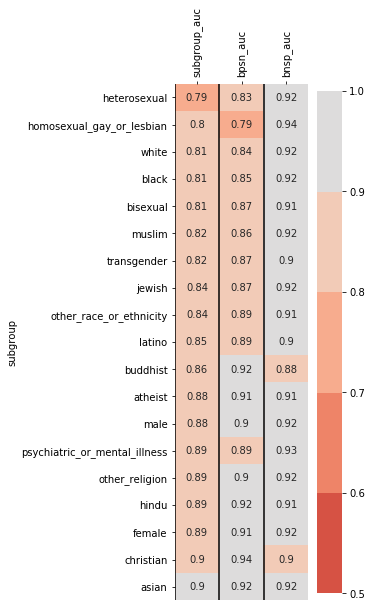

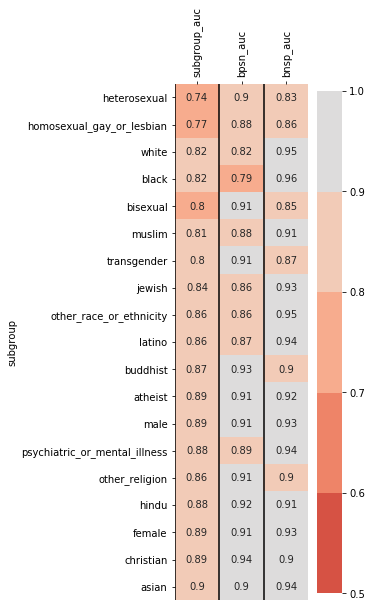

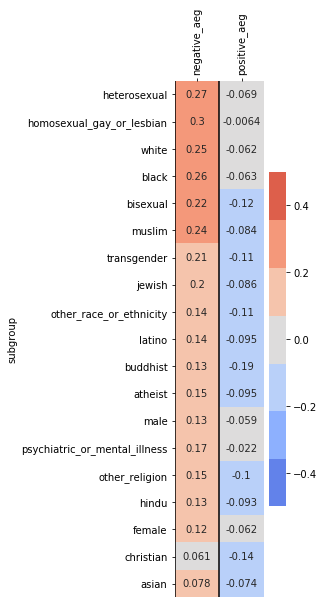

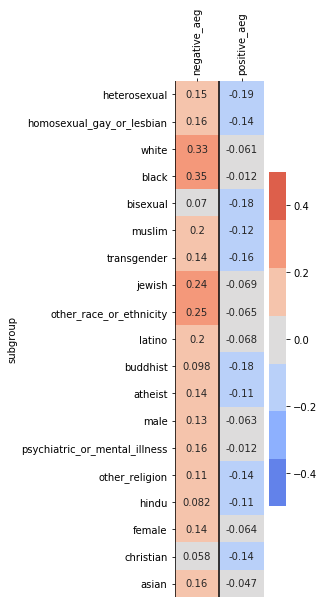

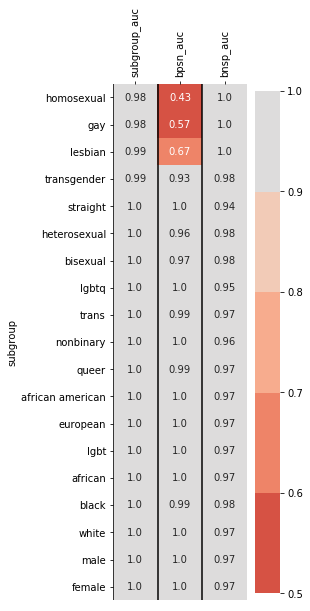

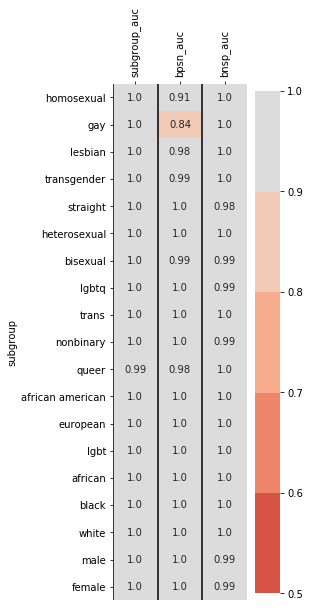

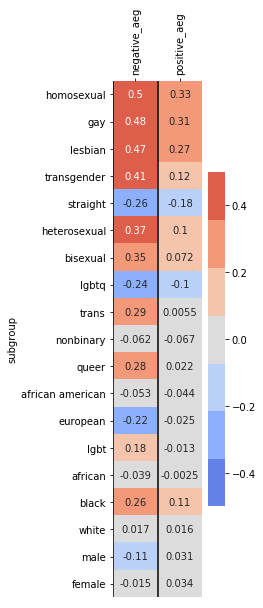

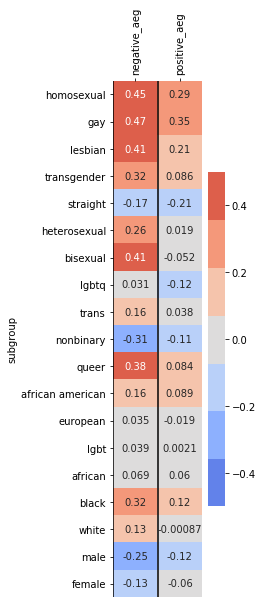

In [39]:
# Print Civil Comments heatmaps
CIVIL_COMMENTS_HEATMAP_IDENTITIES = get_identities_over_n(civil_comments_df, 100, civil_comments_identity_terms)
print_auc_heatmap(civil_comments_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'Rock:TOXICITY')
print_auc_heatmap(civil_comments_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'RockV6_2:TOXICITY')
print_aeg_heatmap(civil_comments_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'Rock:TOXICITY')
print_aeg_heatmap(civil_comments_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'RockV6_2:TOXICITY')

# Print Madlibs heatmaps, using same number of identities as civil comments
num_identities = len(CIVIL_COMMENTS_HEATMAP_IDENTITIES)
MADLIB_HEATMAP_IDENTITIES = madlibs_identity_terms[:num_identities]
print_auc_heatmap(madlibs_bias_metrics, MADLIB_HEATMAP_IDENTITIES, 'Rock:TOXICITY')
print_auc_heatmap(madlibs_bias_metrics, MADLIB_HEATMAP_IDENTITIES, 'RockV6_2:TOXICITY')
print_aeg_heatmap(madlibs_bias_metrics, MADLIB_HEATMAP_IDENTITIES, 'Rock:TOXICITY')
print_aeg_heatmap(madlibs_bias_metrics, MADLIB_HEATMAP_IDENTITIES, 'RockV6_2:TOXICITY')